In [9]:
import numpy as np
import matplotlib as plt
import pandas as pd

In [68]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [86]:
df = pd.read_csv(r'C:\Users\james\AppData\Local\Temp\Temp1_199387_1319582_bundle_archive.zip\US_Accidents_June20.csv')

#Smaller sample
df = df.sample(n=100000, random_state=42)

In [11]:
unique_cats = df.select_dtypes('object').nunique()
unique_cats

ID                       100000
Source                        3
Start_Time                99622
End_Time                  99700
Description               87545
Street                    28209
Side                          2
City                       5743
County                     1169
State                        48
Zipcode                   33202
Country                       1
Timezone                      4
Airport_Code               1531
Weather_Timestamp         72356
Wind_Direction               24
Weather_Condition            77
Sunrise_Sunset                2
Civil_Twilight                2
Nautical_Twilight             2
Astronomical_Twilight         2
dtype: int64

In [12]:
#High cardinality categories
high_card = [col for col in unique_cats.index if unique_cats[col]>127]
high_card

['ID',
 'Start_Time',
 'End_Time',
 'Description',
 'Street',
 'City',
 'County',
 'Zipcode',
 'Airport_Code',
 'Weather_Timestamp']

In [87]:
def wrangle(X):
    X = X.copy()
    #Drop high cardinality columns
    X.drop(high_card, axis=1, inplace=True)
    
    #Drop more columns- country and turning loop only have 1 unique value
    X.drop(['Turning_Loop', 'Country'], axis=1, inplace=True)
    
    #Drop columns with high percentage of NaNs
    X.drop(['End_Lat', 'End_Lng', 'Number', 'Wind_Chill(F)', 'Precipitation(in)'],axis=1, inplace=True)
    
    #Putting Times in datetime format
    #Add year, month, day, hour, and weekday columns
    X['Start_Time']= pd.to_datetime(df['Start_Time'])
    X['End_Time']= pd.to_datetime(df['End_Time'])
    X['year'] = X['Start_Time'].dt.year
    X['month'] = X['Start_Time'].dt.strftime('%b')
    X['day'] = X['Start_Time'].dt.day
    X['hour'] = X['Start_Time'].dt.hour
    X['Weekday']=X['Start_Time'].dt.strftime('%a')
    
    #Add a season column
    date = X.Start_Time.dt.month*100 + X.Start_Time.dt.day
    X['Season'] = (pd.cut(date,[0,321,620,922,1220,1300],
                       labels=['Winter','Spring','Summer','Autumn','Winter ']).str.strip()
               )
    X['Season'].replace('Winter ', 'Winter')

    X['Traffic_disruption(min)'] = round((X['End_Time'] - X['Start_Time'])/np.timedelta64(1,'m'))
    X.drop(['Start_Time', 'End_Time'], axis=1, inplace=True)

    td = 'Traffic_disruption(min)'
    
    #Set negative time values to NaN
    X[X[td] <= 0] = np.nan
    X.dropna(subset=[td], axis=0, inplace=True)

    #X = X[(X[td] >= np.percentile(X[td], 0.5)) & 
        #(X[td] <= np.percentile(X[td], 99.5))]
    
    #Drop features with 0 importance
    X.drop(['No_Exit', 'Roundabout', 'Traffic_Calming', 'Bump'], axis=1, inplace=True)
    
    #Drop features with negative permutation importance
    X.drop(['Sunrise_Sunset', 'Wind_Direction', 'Nautical_Twilight'], 
           axis=1, inplace=True)
    
    X['Severe'] = X['Severity']>=3
    X.drop('Severity', axis=1, inplace=True)
    
    return X

In [88]:
df = wrangle(df)

In [15]:
df.head()

,Source,TMC,Start_Lat,Start_Lng,Distance(mi),Side,State,Timezone,Temperature(F),Humidity(%),...,Civil_Twilight,Astronomical_Twilight,year,month,day,hour,Weekday,Season,Traffic_disruption(min),Severe
3173614,Bing,NaN,40.847160,-73.933490,0.583,R,NY,US/Eastern,26.1,88.0,...,Day,Day,2019.0,Mar,1.0,6.0,Fri,Winter,29.0,False
2560694,Bing,NaN,39.290699,-84.443617,0.051,R,OH,US/Eastern,84.9,55.0,...,Day,Day,2016.0,Aug,30.0,18.0,Tue,Summer,360.0,True
708186,MapQuest,201.0,33.483852,-82.083969,0.000,R,GA,US/Eastern,64.0,84.0,...,Night,Night,2020.0,Feb,11.0,4.0,Tue,Winter,185.0,False
2231588,MapQuest,241.0,36.560585,-79.882690,0.000,L,VA,US/Eastern,77.0,51.0,...,Day,Day,2017.0,Nov,3.0,12.0,Fri,Autumn,45.0,False
1755423,MapQuest,201.0,43.071461,-73.751770,0.000,R,NY,US/Eastern,82.4,37.0,...,Day,Day,2018.0,Jul,6.0,15.0,Fri,Summer,30.0,True


<AxesSubplot:title={'center':'traffic disruption hist'}, ylabel='Frequency'>

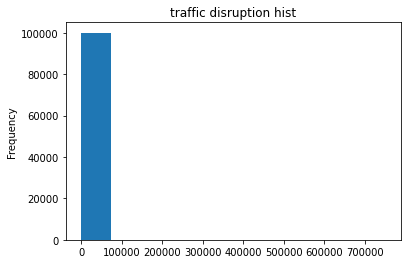

In [89]:
df['Traffic_disruption(min)'].plot.hist(title='traffic disruption hist')

In [18]:
target = 'Severe'

y = df[target]
X = df.drop(target, axis=1)

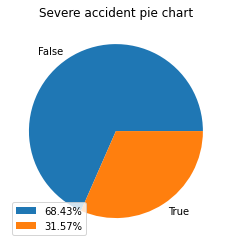

In [120]:
plt.pie(y.value_counts(normalize=True), labels = ['False', 'True'])
plt.legend(['68.43%', '31.57%'], loc='lower left')
plt.title('Severe accident pie chart')
plt.show()

In [100]:
y.value_counts(normalize=True)

False    0.684279
True     0.315721
Name: Severe, dtype: float64

In [20]:
#Baseline accuracy
baseline_acc = y.value_counts(normalize=True).max()
print('Baseline accuracy:',baseline_acc)

Baseline accuracy: 0.6842787649754764


In [21]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(df, test_size=.2, random_state=42)
X_train, y_train = train.drop(target, axis=1), train[target]
X_val, y_val = val.drop(target, axis=1), val[target]

In [22]:
print(train.shape, val.shape, df.shape)

(79596, 32) (19900, 32) (99496, 32)


# Logistic Regression

In [23]:
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from xgboost import XGBClassifier

In [24]:
model = make_pipeline(
        OrdinalEncoder(),
        SimpleImputer(strategy='most_frequent'),
        LogisticRegression(n_jobs=-1)
)
model.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Source', 'Side', 'State', 'Timezone',
                                      'Weather_Condition', 'Civil_Twilight',
                                      'Astronomical_Twilight', 'month',
                                      'Weekday', 'Season'],
                                mapping=[{'col': 'Source',
                                          'data_type': dtype('O'),
                                          'mapping': MapQuest         1
Bing             2
MapQuest-Bing    3
NaN             -2
dtype: int64},
                                         {'col': 'Side',
                                          'data_type': dtype('O'),
                                          'mapping': R      1
L      2
NaN   -2
dtype: int64...
Mar     7
Jun     8
Jan     9
Sep    10
May    11
Apr    12
NaN    -2
dtype: int64},
                                         {'col': 'Weekday',
                                          'd

In [25]:
print("Training accuracy:", model.score(X_train,y_train))
print("Validation accuracy:", model.score(X_val,y_val))

Training accuracy: 0.7018694406754108
Validation accuracy: 0.711608040201005


Text(0.5, 1.0, 'Confusion Matrix: Logistic regression model')

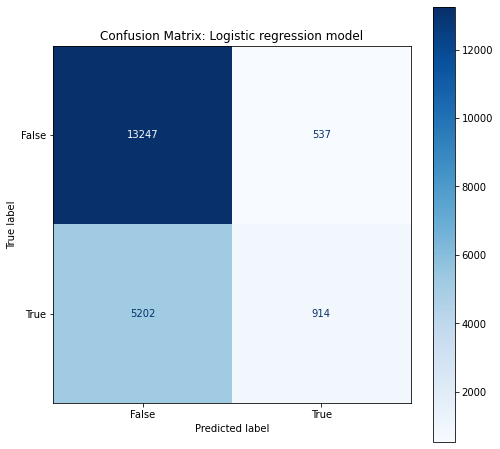

In [26]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(8,8))

plot_confusion_matrix(model, X_val, y_val, cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix: Logistic regression model')

# Decision Tree Model

In [27]:
model_dt = make_pipeline(       
        OrdinalEncoder(),
        SimpleImputer(strategy='median'),
        DecisionTreeClassifier()
)
model_dt.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Source', 'Side', 'State', 'Timezone',
                                      'Weather_Condition', 'Civil_Twilight',
                                      'Astronomical_Twilight', 'month',
                                      'Weekday', 'Season'],
                                mapping=[{'col': 'Source',
                                          'data_type': dtype('O'),
                                          'mapping': MapQuest         1
Bing             2
MapQuest-Bing    3
NaN             -2
dtype: int64},
                                         {'col': 'Side',
                                          'data_type': dtype('O'),
                                          'mapping': R      1
L      2
NaN   -2
dtype: int64...
Feb     5
Aug     6
Mar     7
Jun     8
Jan     9
Sep    10
May    11
Apr    12
NaN    -2
dtype: int64},
                                         {'col': 'Weekday',
                        

In [28]:
print("Training accuracy:", model_dt.score(X_train,y_train))
print("Validation accuracy:", model_dt.score(X_val,y_val))

Training accuracy: 0.9999874365546008
Validation accuracy: 0.7431155778894473


Text(0.5, 1.0, 'Confusion Matrix: Decision Tree')

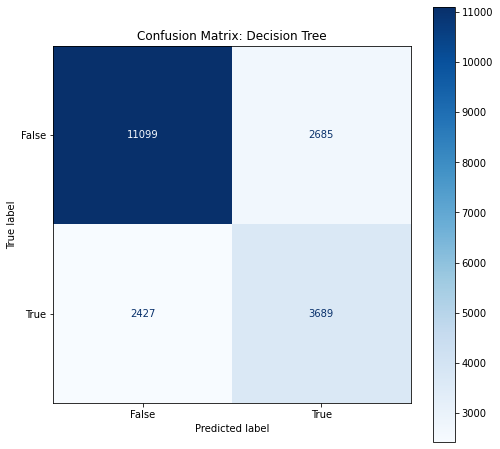

In [29]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

plot_confusion_matrix(model_dt, X_val, y_val, cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix: Decision Tree')

In [140]:
# Decision tree
transformer = make_pipeline(
        OrdinalEncoder(),
        SimpleImputer()
)
XT_train = transformer.fit_transform(X_train)
XT_val = transformer.fit_transform(X_val)

accuracy_train = []
accuracy_test = []

for i in range(1, 100, 5):
    tree = DecisionTreeClassifier(max_depth=i)
    tree.fit(XT_train, y_train)
    accuracy_test.append(tree.score(XT_val, y_val))
    accuracy_train.append(tree.score(XT_train, y_train))

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [137]:
# Random forest
rf_accuracy_train = []
rf_accuracy_test = []

for i in range(1, 100, 5):
    tree = RandomForestClassifier(max_depth=i)
    tree.fit(XT_train, y_train)
    rf_accuracy_test.append(tree.score(XT_val, y_val))
    rf_accuracy_train.append(tree.score(XT_train, y_train))

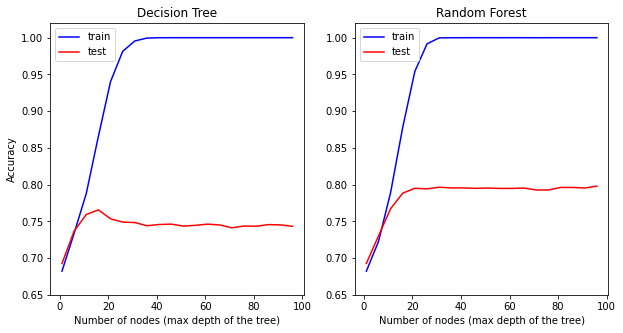

In [141]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

xvals = range(1, 100, 5)
ax1.plot(xvals, accuracy_train, color='b', label='train')
ax1.plot(xvals, accuracy_test, color='red', label='test')
ax1.legend()

ax2.plot(xvals, rf_accuracy_train, color='b', label='train')
ax2.plot(xvals, rf_accuracy_test, color='red', label='test')
ax2.legend()

ax1.set_ylim([0.65, 1.02])
ax2.set_ylim([0.65, 1.02])

ax1.set_xlabel('Number of nodes (max depth of the tree)')
ax2.set_xlabel('Number of nodes (max depth of the tree)')
ax1.set_ylabel('Accuracy')
ax1.set_title('Decision Tree')
ax2.set_title('Random Forest')

plt.show()

# Random Forest Model

In [30]:
model_rf = make_pipeline(
        OrdinalEncoder(),
        SimpleImputer(),
        RandomForestClassifier(n_estimators=100,random_state=0,n_jobs=-1)
)
model_rf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Source', 'Side', 'State', 'Timezone',
                                      'Weather_Condition', 'Civil_Twilight',
                                      'Astronomical_Twilight', 'month',
                                      'Weekday', 'Season'],
                                mapping=[{'col': 'Source',
                                          'data_type': dtype('O'),
                                          'mapping': MapQuest         1
Bing             2
MapQuest-Bing    3
NaN             -2
dtype: int64},
                                         {'col': 'Side',
                                          'data_type': dtype('O'),
                                          'mapping': R      1
L      2
NaN   -2
dtype: int64...
Mar     7
Jun     8
Jan     9
Sep    10
May    11
Apr    12
NaN    -2
dtype: int64},
                                         {'col': 'Weekday',
                                          'd

In [31]:
print("Training accuracy:", model_rf.score(X_train,y_train))
print("Validation accuracy:", model_rf.score(X_val,y_val))

Training accuracy: 0.9999748731092014
Validation accuracy: 0.7951256281407035


Text(0.5, 1.0, 'Confusion Matrix: Random Forest')

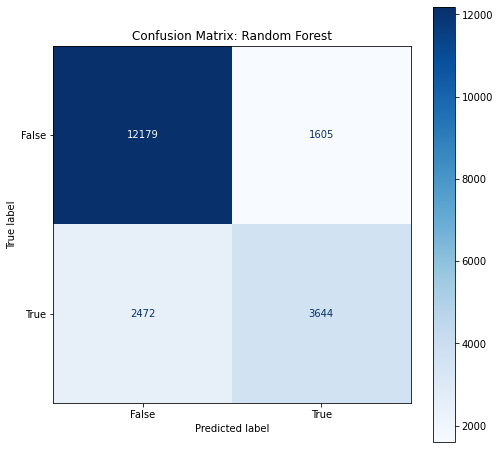

In [32]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

plot_confusion_matrix(model_rf, X_val, y_val, cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix: Random Forest')

# XGBClassifier Model

In [36]:
transformer = OrdinalEncoder()
transformer.fit(X_train)
XT_train = transformer.transform(X_train)
XT_val = transformer.transform(X_val)

In [143]:
# Load xgboost and fit the model
xg_classifier = XGBClassifier(n_estimators=100, random_state=42)

xg_classifier.fit(XT_train,y_train)

print('Training Accuracy:', xg_classifier.score(XT_train, y_train))
print('Validation Accuracy:', xg_classifier.score(XT_val, y_val))

Training Accuracy: 0.8589125081662395
Validation Accuracy: 0.8158793969849246


Text(0.5, 1.0, 'Confusion Matrix: XG_classifier')

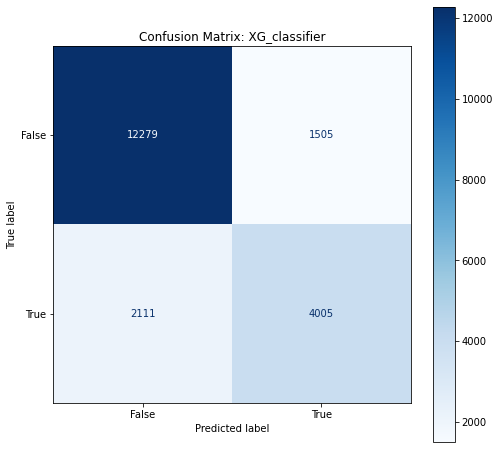

In [38]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

plot_confusion_matrix(xg_classifier, XT_val, y_val, cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix: XG_classifier')

<AxesSubplot:>

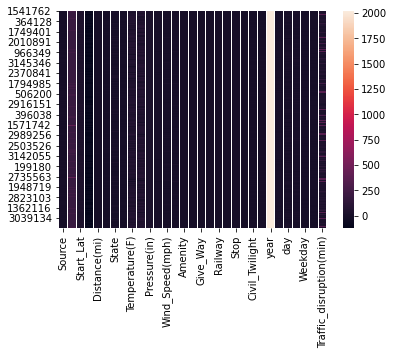

In [84]:
import seaborn as sns
sns.heatmap(XT_train)

# Model Evaluation

In [145]:
from sklearn.metrics import roc_auc_score, roc_curve
y_prob = xg_classifier.predict_proba(XT_val)[:,-1]

print('ROC_AUC_score:',roc_auc_score(y_val, y_prob))

ROC_AUC_score: 0.8818379284595329


In [ ]:
# Create the data for the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_prob)

# See the results in a table
roccurve_df = pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})

roccurve_df

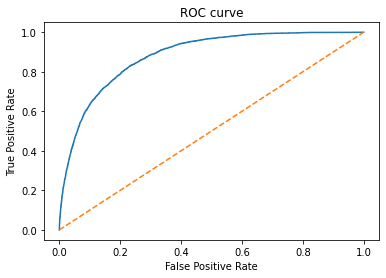

In [49]:
# Plot the ROC curve
import matplotlib.pyplot as plt

plt.plot(fpr, tpr)
plt.plot([0,1], ls='--')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.savefig('mod4_obj4_ROC.png', transparent=False, dpi=150);

# Model Interpretation

In [82]:
import shap

row = XT_val.iloc[[0]]
explainer = shap.TreeExplainer(xg_classifier)
shap_values = explainer.shap_values(row)
shap_values

array([[-1.0132901e-03, -7.4883595e-02, -3.2931367e-01, -1.1037495e+00,
         5.9758835e-02,  3.2039768e-01,  1.4286339e-02,  4.7125798e-03,
        -1.5653308e-01, -4.5337821e-03, -1.4690682e-03,  1.7684041e-02,
         4.4413805e-02,  1.0953696e-01,  7.5933752e-03,  3.5663478e-02,
        -9.4134120e-05, -2.1094292e-02, -1.3100309e-03,  1.6365383e-02,
         1.6015038e-02,  1.6505168e-01, -3.5471991e-03, -4.6148524e-03,
         2.0353608e-01,  3.7443610e-03,  4.9853779e-02, -2.2062799e-01,
        -7.5470462e-02,  8.3492436e-02, -1.8177108e-01]], dtype=float32)

In [83]:
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)

# Permutation Importances

In [50]:
transform_pipeline = make_pipeline(
                    OrdinalEncoder(),
                    SimpleImputer(strategy='median')
)
X_train_transformed = transform_pipeline.fit_transform(X_train)
X_val_transformed = transform_pipeline.fit_transform(X_val)

model = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

C:\Users\james\miniconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [51]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)
permuter.fit(X_val_transformed, y_val)

C:\Users\james\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\james\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


PermutationImportance(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              gpu_id=-1, importance_type='gain',
                                              interaction_constraints='',
                                              learning_rate=0.300000012,
                                              max_delta_step=0, max_depth=6,
                                              min_child_weight=1, missing=nan,
                                              monotone_constraints='()',
                                              n_estimators=100, n_jobs=-1,
                                              num_parallel_tree=1,
                                              random_state=42, reg_alpha=0,
                                     

In [56]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19900 entries, 326487 to 500836
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Source                   19900 non-null  object 
 1   TMC                      14093 non-null  float64
 2   Start_Lat                19900 non-null  float64
 3   Start_Lng                19900 non-null  float64
 4   Distance(mi)             19900 non-null  float64
 5   Side                     19900 non-null  object 
 6   State                    19900 non-null  object 
 7   Timezone                 19877 non-null  object 
 8   Temperature(F)           19531 non-null  float64
 9   Humidity(%)              19505 non-null  float64
 10  Pressure(in)             19591 non-null  float64
 11  Visibility(mi)           19467 non-null  float64
 12  Wind_Speed(mph)          17352 non-null  float64
 13  Weather_Condition        19471 non-null  object 
 14  Amenity         

In [58]:
feature_names = X_val.columns.tolist()
importances = pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

importances

Start_Lng                  0.071437
Start_Lat                  0.065005
Source                     0.052392
Side                       0.028503
Distance(mi)               0.019879
Traffic_Signal             0.018734
State                      0.017668
Traffic_disruption(min)    0.013307
hour                       0.011447
TMC                        0.009980
Weekday                    0.009216
year                       0.006874
Crossing                   0.004603
Junction                   0.003950
Pressure(in)               0.002955
Humidity(%)                0.002663
Stop                       0.002482
Station                    0.001357
Weather_Condition          0.001236
month                      0.001035
Season                     0.001025
Astronomical_Twilight      0.000995
Amenity                    0.000945
Civil_Twilight             0.000925
Visibility(mi)             0.000905
day                        0.000874
Temperature(F)             0.000472
Timezone                   0

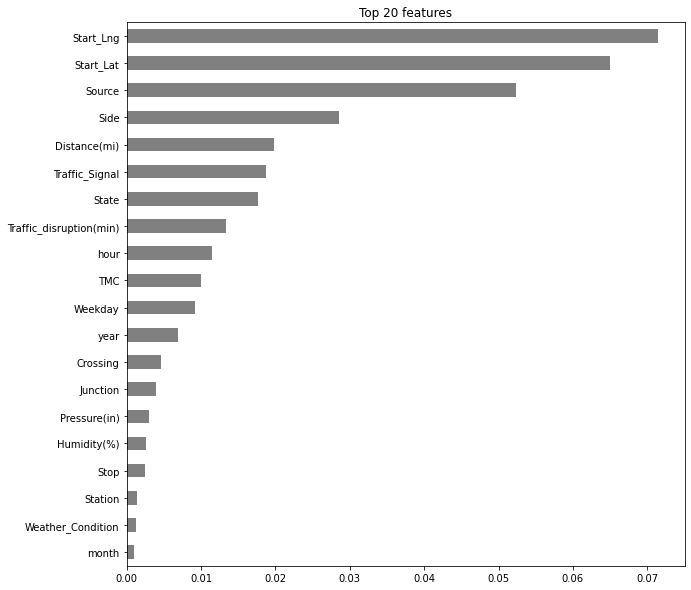

In [59]:
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey')

plt.savefig('mod3_obj1_features.png', transparent=False, dpi=150)

# Tune Model

In [243]:
XGBClassifier().get_params().keys()

dict_keys(['objective', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])